In [2]:
import json
import requests
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error
%matplotlib inline

In [3]:
hist = pd.read_csv('btc-train.csv')
hist.shape
hist.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-03-01,437.916992,439.653015,432.319000,435.122986,435.122986,74895800
1,2016-03-02,435.131012,435.916992,423.989014,423.989014,423.989014,74955296
2,2016-03-03,423.911987,425.372986,419.411011,421.651001,421.651001,100484000
3,2016-03-04,421.835999,425.178009,410.938995,410.938995,410.938995,90856096
4,2016-03-05,410.781006,411.256989,394.035004,400.570007,400.570007,135384992


In [4]:
hist.dtypes

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

In [5]:
hist=hist.drop(['Date'],axis=1)

In [6]:
hist.dtypes

Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

In [7]:
target_col = 'Close'

In [8]:
hist=hist.dropna()

In [9]:
def train_test_split(df, test_size=0.2):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

In [10]:
train, test = train_test_split(hist, test_size=0.2)

In [11]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price [CAD]', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16);

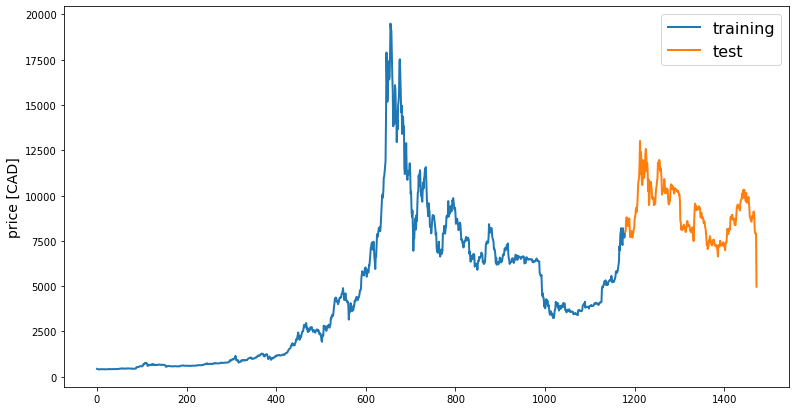

In [12]:
line_plot(train[target_col], test[target_col], 'training', 'test', title='')

In [13]:

def normalise_zero_base(df):
    return df / df.iloc[0] - 1

def normalise_min_max(df):
    return (df - df.min()) / (data.max() - df.min())

In [14]:
def extract_window_data(df, window_len=5, zero_base=True):
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

In [15]:
def prepare_data(df, target_col, window_len=10, zero_base=True, test_size=0.2):
    train_data, test_data = train_test_split(df, test_size=test_size)
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
    if zero_base:
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test

In [16]:
def build_lstm_model(input_data, output_size, neurons=100, activ_func='linear',
                     dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [17]:
np.random.seed(42)
window_len = 5
test_size = 0.2
zero_base = True
lstm_neurons = 100
epochs = 20
batch_size = 32
loss = 'mse'
dropout = 0.2
optimizer = 'adam'

In [18]:
train, test, X_train, X_test, y_train, y_test = prepare_data(
    hist, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)

In [19]:
model = build_lstm_model(
    X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)
history = model.fit(
    X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/20
37/37 [==============================] - 0s 4ms/step - loss: 0.0055
Epoch 2/20
37/37 [==============================] - 0s 3ms/step - loss: 0.0032
Epoch 3/20
37/37 [==============================] - 0s 3ms/step - loss: 0.0027
Epoch 4/20
37/37 [==============================] - 0s 3ms/step - loss: 0.0024
Epoch 5/20
37/37 [==============================] - 0s 3ms/step - loss: 0.0023
Epoch 6/20
37/37 [==============================] - 0s 3ms/step - loss: 0.0022
Epoch 7/20
37/37 [==============================] - 0s 3ms/step - loss: 0.0020
Epoch 8/20
37/37 [==============================] - 0s 3ms/step - loss: 0.0020
Epoch 9/20
37/37 [==============================] - 0s 3ms/step - loss: 0.0020
Epoch 10/20
37/37 [==============================] - 0s 3ms/step - loss: 0.0020
Epoch 11/20
37/37 [==============================] - 0s 3ms/step - loss: 0.0019
Epoch 12/20
37/37 [==============================] - 0s 3ms/step - loss: 0.0020
Epoch 13/20
37/37 [==============================

In [20]:
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()
mean_absolute_error(preds, y_test)

0.02627269679867619

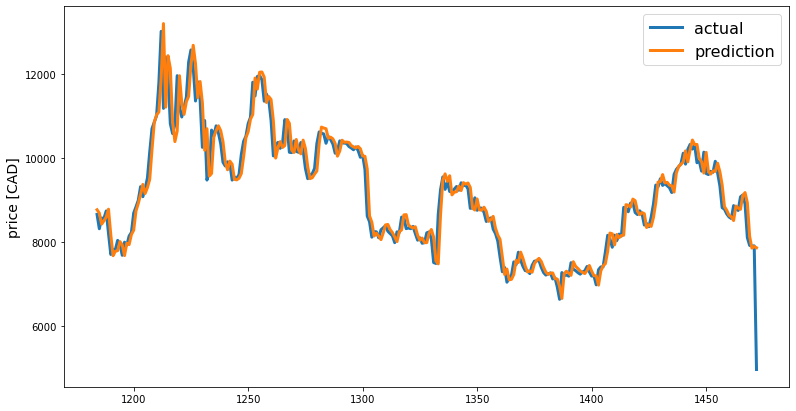

In [21]:
preds = test[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'actual', 'prediction', lw=3)